# Hyperparameter Tuning "From Scratch"
Here, we are tuning hyperparameters for a Random Forest Classifier. Since we're using a Gaussian Process surrogate model, the hyperparameters - **n_estimators** (the number of trees in the forest) and **max_depth** (of each decision tree) - are treated as continuous variables during optimization.

Increasing the number of trees generally improves accuracy on unseen data and reduces variance (i.e., overfitting), but only up to a point. Too many trees can increase training time and memory usage without significant gains in accuracy. 

Deeper trees can model more complex patterns and may overfit, while shallower trees are faster to evaluate but may underfit. 

I chose 2 hyperparameters because it's much easier to visualize for the Bayesian optimization portion.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

We use the raw Iris dataset, which contains 150 samples of iris flowers from 3 different species. Each sample has 4 features (sepal length, sepal width, petal length, and petal width).

Feature scaling is important when features have different units or scales, and is essential for algorithms that rely on distance calculations or gradients, but not needed for tree-based models like random forests, which can handle mixed feature scales and types by splitting based on feature thresholds. 


In [3]:
seed = 11

iris = load_iris()
X = iris.data # sepal length, sepal width, petal length, petal width
print(X.shape) # (150, 4)
y = iris.target
print(y.shape) # (150, )

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df

(150, 4)
(150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [5]:
# 80% of data for training (120), 20% for testing (30), shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# print(X_train)
# print(X_test)


## Training an RF Classifier 
At this point, we're not performing any hyperparameter tuning. 

Accuracy:  0.9333333333333333
[[ 9  0  0]
 [ 0 10  0]
 [ 0  2  9]]
['setosa' 'versicolor' 'virginica']


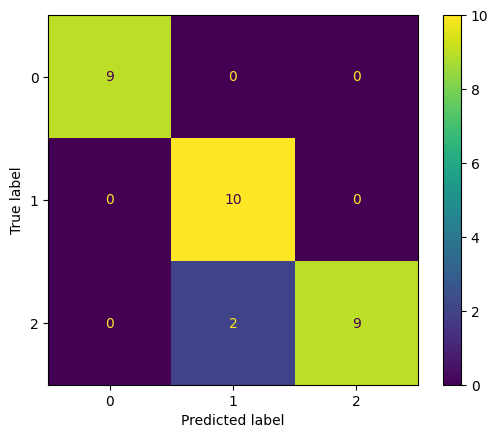

In [4]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=seed)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy) # about 93%

# Confusion matrix
# 0 = setosa, 1 = versicolor, 2 = virginica
# Rows = actual true labels
# Columns = Predicted labels
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)
print(iris.target_names)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)



## Hyperparameter Tuning
Now we'll use Bayesian Optimization with a Gaussian Process surrogate model to tune the hyperparameters of the Random Forest. 

We are trying to approximate the following function to predict which set of hyperparameters performs best:
    $$f(θ)=\text{CV score of model with hyperparameters } θ$$
where:
- $\theta$ = a set of hyperparameters (n_estimators, max_depth)
- $f(\theta)$ = the model's performance (accuracy, F-1, etc.)


In [28]:
def objective(X):
    """
    X: a set of [n_estimators, max_depth] inputs

    returns an array of scores for each input
    """
    scores = []
    for param in X: # iterate through each input
        model = RandomForestClassifier(n_estimators=int(param[0]), max_depth=int(param[1]), random_state=seed)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
        # print(score)
        scores.append(score)
    return np.array(scores).reshape(-1,1)

## BO + GP Code
For the BO portion, we use a GP surrogate model with an RBF kernel and a UCB acquisition function. Our prior distribution assumes a mean of 0 for all inputs. 

In [29]:
def squared_euclidean_distance(xa, xb):
     # ||a - b||^2 = ||a||^2 + ||b||^2 - 2a⋅b
    # Reduce (n,d) to (n,1), (m,d) to (1,m)
    xa2 = np.sum(xa**2, axis=1).reshape(-1, 1)   # shape: (n,1)
    xb2 = np.sum(xb**2, axis=1).reshape(1, -1)   # shape: (1,m)

    # print("xa2:", xa2)
    # print("xb2:", xb2)

    # Compute pairwise dot products
    dot_prod = np.dot(xa, xb.T)                  # shape: (n,m)

    # Apply the distance formula
    return xa2 + xb2 - 2 * dot_prod              # shape: (n,m)

    
def rbf_kernel(xa, xb, sigma=1):
    sqdist = squared_euclidean_distance(xa, xb)
    return np.exp(-0.5 * 1/(sigma**2) * sqdist)


def GP(X1, y1, X2, sigma=1.0, noise=0):
    """
    Compute the posterior mean and covariance of a Gaussian Process with RBF Kernel. 

    Parameters:
    - X1: (n,d) array of n d-dimensional training inputs
    - y1: (n,1) array of n training outputs
    - X2: (m,d) array of m d-dimensional test inputs (where we want to predict)
    - sigma: RBF kernel parameter (length scale)
    - noise: for modeling noise (standard deviation, not variance) 

    Returns:
    - mu: (m,1) posterior mean or m predicted values for X2
    - cov: (m,m) posterior covariance matrix for X2
    """
    # In case 1D array passed
    y1 = y1.reshape(-1, 1)
    
    # Kernel (covariance) matrices
    # Add noise on diagonal for K11
    K11 = rbf_kernel(X1, X1, sigma) + (noise**2) * np.eye(len(X1)) + 1e-8 * np.eye(len(X1)) # shape: (n,n)
    K22 = rbf_kernel(X2, X2, sigma)                                # shape: (m,m)
    K12 = rbf_kernel(X1, X2, sigma)                                # shape: (n,m)

    # Invert K11
    K11_inv = np.linalg.inv(K11)

    # Posterior mean
    mu = K12.T @ K11_inv @ y1 # # @ is matrix multiplication

    # Posterior covariance
    cov = K22 - K12.T @ K11_inv @ K12

    return mu, cov


# Acquisition function: UCB
def acquisition_ucb(mu, std, beta=2.0):
    return mu + beta * std

def bayesian_opt(objective, bounds, init_points=5, iterations=10, beta=2.0, sigma=1.0, noise=0):
    """
    objective: the objective function
    bounds: range of values for variable(s) within X ([[low for each variable], [high for each variable]])
    init_points: size of initial training dataset
    beta: UCB acquisition parameter
    sigma: RBF kernel parameter
    noise: standard deviation, not variance
    """
    # Initial data (set of [n_estimators, max_depth] inputs)
    # This is not the data used to train the classifier, renamed to avoid duplicated variable names
    X_param_train = np.random.uniform(bounds[0], bounds[1], size=(init_points, len(bounds)))
    y_param_train = objective(X_param_train) # set of scores

    print("X_param_train: ", X_param_train)
    print("y_param_train: ", y_param_train)

    # Evaluation grid for plotting and acquisition
    # Make a grid of 100 points along each dimension
    x1 = np.linspace(bounds[0][0], bounds[1][0], 100)
    x2 = np.linspace(bounds[0][1], bounds[1][1], 100)
    # Make a grid of 2D points for prediction
    # meshgrid creates all combinations of x1 and x2 
    X1, X2 = np.meshgrid(x1, x2) 
    # each point is [x1, x2], or [n_estimators, max_depth]
    X_grid = np.vstack([X1.ravel(), X2.ravel()]).T # 10000 input points (10000, 2)
    print("X_grid: ", X_grid)
    
    mu = None
    cov = None
    std = None
    best_hyperparam = None
    best_cv_score = float('-inf')
    for i in range(iterations):
        print(f"Iteration {i}")
        # Update surrogate, get predictions for X_grid
        mu, cov = GP(X_param_train, y_param_train, X_grid, sigma, noise)
        print("Mean: ", mu)
        print("Covariance: ", cov)

        # Standard deviation for uncertainty 
        std = np.sqrt(np.diag(cov)).reshape(-1, 1)

        # Score each X_grid input
        scores = acquisition_ucb(mu, std)
        print("Scores: ", scores)
        print("Scores shape: ", scores.shape)

        # Choose next point from X_grid
        next_x = np.array([X_grid[np.argmax(scores)]]) # maximize acquisition function
        print("Next x: ", next_x)
        next_y = objective(next_x)
        print("Next y: ", next_y)

        if next_y[0,0] > best_cv_score:
            best_cv_score = next_y[0,0]
            best_hyperparam = next_x

        # Append to training data
        X_param_train = np.vstack((X_param_train, next_x.reshape(1, -1)))
        y_param_train = np.vstack((y_param_train, next_y.reshape(1, -1)))

    return best_hyperparam

[[-0.95833333]
 [-0.95833333]
 [-0.95833333]
 [-0.94166667]
 [-0.94166667]]
(10000, 2)
[[ 1.          9.        ]
 [ 1.02020202  9.        ]
 [ 1.04040404  9.        ]
 ...
 [ 2.95959596 20.        ]
 [ 2.97979798 20.        ]
 [ 3.         20.        ]]
None


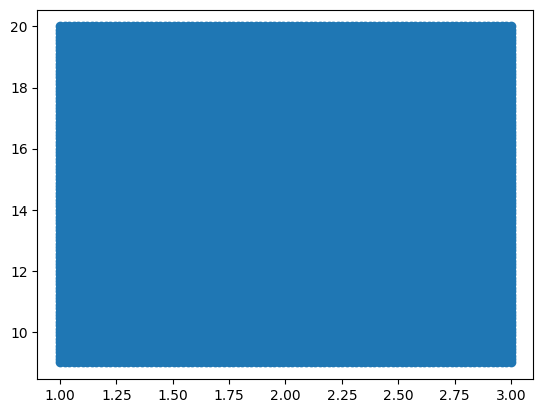

In [11]:
# Code testing
bounds = [[1,9], [3,20]] # (so x1 is from 1 to 3, x2 is from 9 to 20)
X_param_train = np.random.uniform(low=bounds[0], high=bounds[1], size=(5, len(bounds))) 
# print(X_param_train) # (5 data points, 2 variables per data point - n_estimators and max_depth)

y_param_train = objective(X_param_train)
print(y_param_train) # (5 CV scores, )

# Make a grid of 100 points along each dimension
x1 = np.linspace(bounds[0][0], bounds[1][0], 100)
x2 = np.linspace(bounds[0][1], bounds[1][1], 100)
# print(x1)
# print(x2)
# plt.scatter(x1, x2)

# Make a grid of 2D points for prediction
# meshgrid creates all combinations of x1 and x2 
X1, X2 = np.meshgrid(x1, x2) 
# print(X1) # (100, 100)
# print(X2) # (100, 100)
plt.scatter(X1, X2) # should be a grid
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T # each point is a 2D points (x1, x2)
print(X_grid.shape) # (10000, 2)
print(X_grid)

In [30]:
result = bayesian_opt(objective, bounds)
print(result)

X_param_train:  [[ 2.92278804 11.99758925]
 [ 2.15975595 10.08737743]
 [ 1.94660313 14.11551376]
 [ 1.02611057 18.38569464]
 [ 2.89109773 17.54554153]]
y_param_train:  [[0.94166667]
 [0.94166667]
 [0.95833333]
 [0.95833333]
 [0.94166667]]
X_grid:  [[ 1.          9.        ]
 [ 1.02020202  9.        ]
 [ 1.04040404  9.        ]
 ...
 [ 2.95959596 20.        ]
 [ 2.97979798 20.        ]
 [ 3.         20.        ]]
Iteration 0
Mean:  [[0.24084766]
 [0.24652874]
 [0.2522412 ]
 ...
 [0.07679311]
 [0.07534794]
 [0.07392584]]
Covariance:  [[9.19071791e-01 9.16967090e-01 9.14444526e-01 ... 1.71212645e-07
  1.71427352e-07 1.71552976e-07]
 [9.16967090e-01 9.15225830e-01 9.13066222e-01 ... 1.75080902e-07
  1.75300460e-07 1.75428922e-07]
 [9.14444526e-01 9.13066222e-01 9.11269581e-01 ... 1.78960912e-07
  1.79185335e-07 1.79316644e-07]
 ...
 [1.71212645e-07 1.75080902e-07 1.78960912e-07 ... 9.96286730e-01
  9.96144918e-01 9.95594473e-01]
 [1.71427352e-07 1.75300460e-07 1.79185335e-07 ... 9.96144918

Accuracy:  0.8666666666666667
[[9 0 0]
 [0 8 2]
 [0 2 9]]
['setosa' 'versicolor' 'virginica']


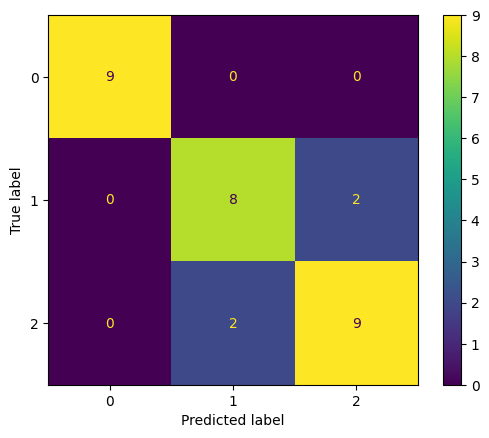

In [32]:
result = result.flatten()
classifier = RandomForestClassifier(n_estimators=int(result[0]), max_depth=int(result[1]), random_state=seed)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy) # about 93%

# Confusion matrix
# 0 = setosa, 1 = versicolor, 2 = virginica
# Rows = actual true labels
# Columns = Predicted labels
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)
print(iris.target_names)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
